## 1.Load the Data

In [31]:
import pandas as pd

# Load the dataset
data = pd.read_csv('C:/Users/basan/Downloads/historic_demand_2009_2024.csv')

# Display the first few rows to understand its structure
print(data.head())

   Unnamed: 0 settlement_date  settlement_period     nd    tsd  \
0           0      2009-01-01                  1  37910  38704   
1           1      2009-01-01                  2  38047  38964   
2           2      2009-01-01                  3  37380  38651   
3           3      2009-01-01                  4  36426  37775   
4           4      2009-01-01                  5  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  ...  ifa2_flow  \
0                          0                        0  ...         

In [32]:
print(data.columns)

Index(['Unnamed: 0', 'settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer',
       'viking_flow', 'is_holiday'],
      dtype='object')


In [33]:
# Rename the column to 'settlement_date' if necessary
data = data.rename(columns={'date': 'settlement_date'})

## 2.Preprocess the Data

In [34]:
# Convert 'settlement_date' to datetime format
data['settlement_date'] = pd.to_datetime(data['settlement_date'])

# Aggregate data by month, calculating the monthly average for demand measures
monthly_data = data.groupby(data['settlement_date'].dt.to_period('M')).agg({
    'england_wales_demand': 'mean'  # You can choose other columns if needed
}).reset_index()

# Convert the period back to datetime for further analysis
monthly_data['settlement_date'] = monthly_data['settlement_date'].dt.to_timestamp()

# Display the monthly aggregated data
print(monthly_data.head())

  settlement_date  england_wales_demand
0      2009-01-01          38363.431452
1      2009-02-01          37625.496280
2      2009-03-01          34313.748991
3      2009-04-01          30886.115278
4      2009-05-01          29407.081989


In [22]:
# Convert settlement_date to datetime format
data['settlement_date'] = pd.to_datetime(data['settlement_date'])

# Aggregate data by month, calculating the monthly average for demand measures
monthly_data = data.groupby(data['settlement_date'].dt.to_period('M')).agg({
    'england_wales_demand': 'mean'  # You can choose other columns if needed
}).reset_index()

# Convert the period back to datetime for further analysis
monthly_data['settlement_date'] = monthly_data['settlement_date'].dt.to_timestamp()

# Display the monthly aggregated data
print(monthly_data.head())

KeyError: 'settlement_date'

## 3. Split the Data for Training and Testing

In [35]:
# Convert dates to numerical format for model training (Unix timestamp)
X = monthly_data[['settlement_date']].apply(lambda x: x.astype('int64') / 10**9)  # Time in seconds since epoch
y = monthly_data['england_wales_demand']

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Ensure the date column is in datetime format
monthly_data['settlement_date'] = pd.to_datetime(monthly_data['settlement_date'])

## 4. Define and Train the Gaussian Process Regressor

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define a kernel: Constant Kernel * RBF Kernel
kernel = C(1.0, (1e-4, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)

# Fit the model on training data
gpr.fit(X_train, y_train)

C:\Users\basan\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

## 5. Make Predictions and Evaluate the Model

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 27685.395492894386
Root Mean Squared Error (RMSE): 27983.761226736602


C:\Users\basan\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


## 6. Visualize the Results

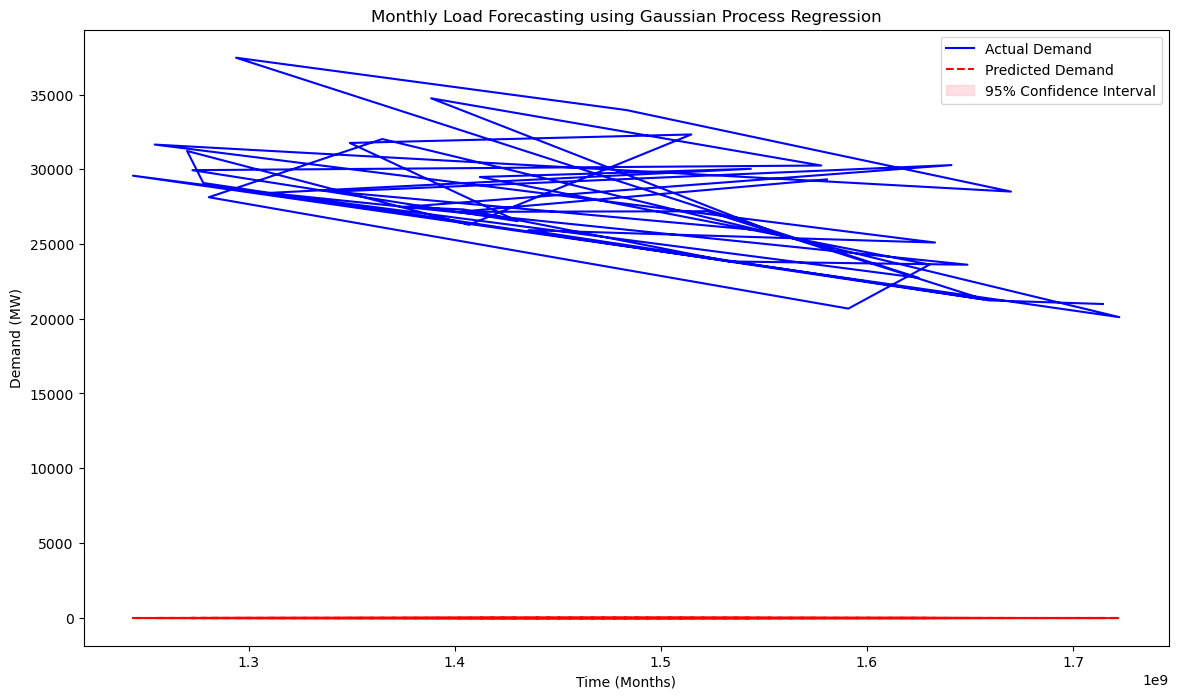

In [9]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(X_test, y_test, 'b-', label='Actual Demand')
plt.plot(X_test, y_pred, 'r--', label='Predicted Demand')
plt.fill_between(X_test.values.flatten(), y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Monthly Load Forecasting using Gaussian Process Regression')
plt.xlabel('Time (Months)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_percentage_error

# Add the original dates back to the test set
X_test['settlement_date'] = monthly_data.loc[X_test.index, 'settlement_date']

# Create a DataFrame to store actual and predicted values with their dates
results = pd.DataFrame({
    'settlement_date': X_test['settlement_date'],
    'actual_demand': y_test.values,
    'predicted_demand': y_pred
})

# Extract the year from the date
results['year'] = results['settlement_date'].dt.year

# Calculate MAPE for each year
mape_by_year = results.groupby('year').apply(
    lambda x: mean_absolute_percentage_error(x['actual_demand'], x['predicted_demand'])
).reset_index(name='MAPE')

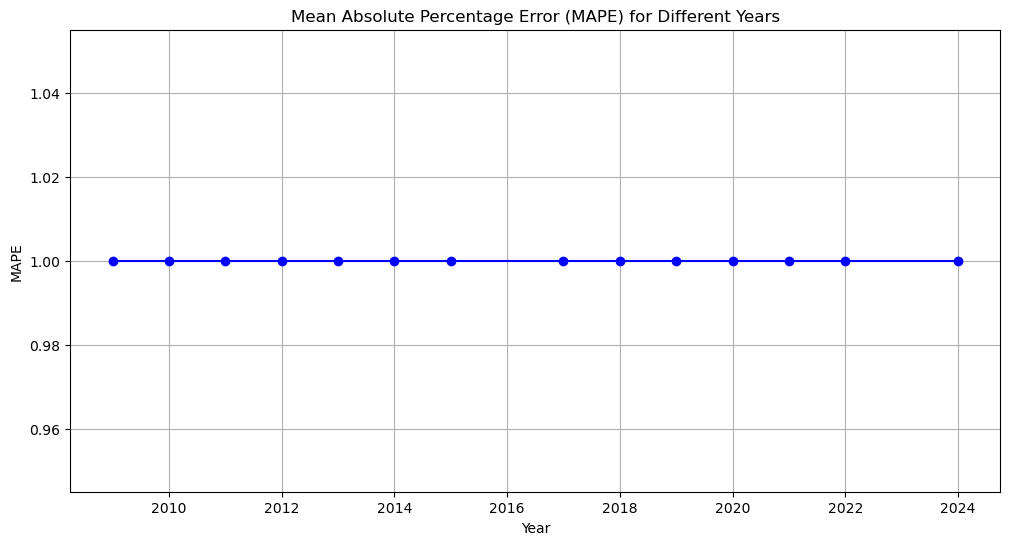

In [11]:
import matplotlib.pyplot as plt

# Plotting MAPE for different years
plt.figure(figsize=(12, 6))
plt.plot(mape_by_year['year'], mape_by_year['MAPE'], marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Percentage Error (MAPE) for Different Years')
plt.xlabel('Year')
plt.ylabel('MAPE')
plt.grid()
plt.show()

C:\Users\basan\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:703: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 840032921.990450
         Iterations: 0
         Function evaluations: 21
         Gradient evaluations: 3
MAPE: 100.00%


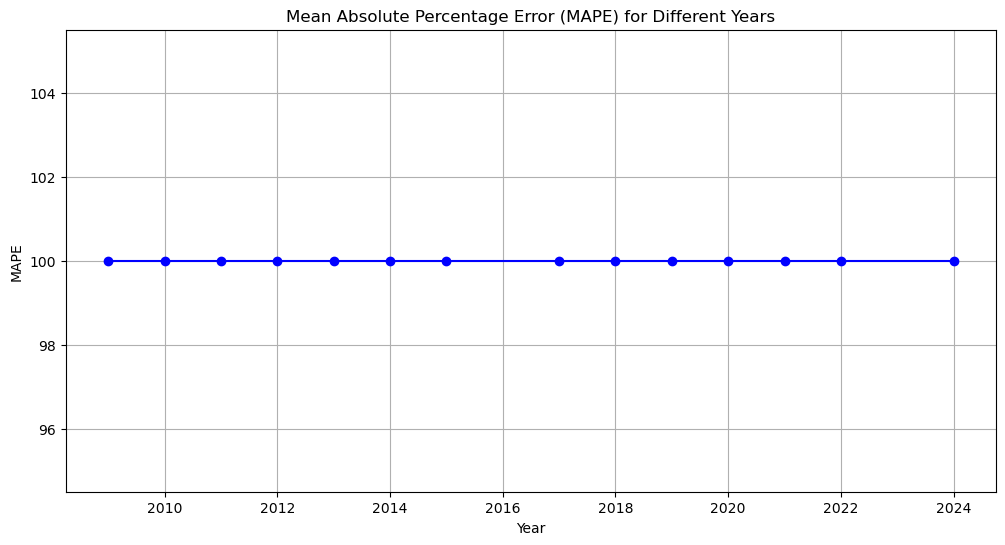

In [39]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Ensure the date column is in datetime format
monthly_data['settlement_date'] = pd.to_datetime(monthly_data['settlement_date'])

# Convert dates to numerical format for model training (Unix timestamp)
X = monthly_data[['settlement_date']].apply(lambda x: x.astype('int64') / 10**9)  # Time in seconds since epoch
y = monthly_data['england_wales_demand']

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function (Mean Squared Error)
def objective_function(params, X, y):
    # Reshape the parameters to fit the model
    intercept, slope = params
    predictions = intercept + slope * X
    return mean_squared_error(y, predictions)

# Initial guess for parameters (intercept and slope)
initial_params = np.array([0, 0])

# Perform optimization using the Polak-Ribiere method with line search
result = minimize(
    objective_function,
    initial_params,
    args=(X_train.values.flatten(), y_train),
    method='CG',  # Conjugate Gradient
    options={'gtol': 1e-5, 'disp': True}  # Set tolerance and display options
)

# Extract optimized parameters
optimized_intercept, optimized_slope = result.x

# Predict using the optimized model
y_pred = optimized_intercept + optimized_slope * X_test.values.flatten()

# Evaluate performance using MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'MAPE: {mape:.2f}%')

# Plotting MAPE for different years
X_test['settlement_date'] = monthly_data.loc[X_test.index, 'settlement_date']
results = pd.DataFrame({
    'settlement_date': X_test['settlement_date'],
    'actual_demand': y_test.values,
    'predicted_demand': y_pred
})

results['year'] = results['settlement_date'].dt.year
mape_by_year = results.groupby('year').apply(
    lambda x: np.mean(np.abs((x['actual_demand'] - x['predicted_demand']) / x['actual_demand'])) * 100
).reset_index(name='MAPE')

# Plot the MAPE values over the years
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mape_by_year['year'], mape_by_year['MAPE'], marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Percentage Error (MAPE) for Different Years')
plt.xlabel('Year')
plt.ylabel('MAPE')
plt.grid()
plt.show()


## 7. Calculate MAPE for each year:

Training Gaussian Process Regressor with RBF kernel...
MAPE for RBF kernel: 99.84%
Training Gaussian Process Regressor with Matérn kernel...
MAPE for Matérn kernel: 99.84%
Training Gaussian Process Regressor with NeuralNet kernel...
MAPE for NeuralNet kernel: 12.78%
Training Gaussian Process Regressor with RationalQuadratic kernel...
MAPE for RationalQuadratic kernel: 99.84%


C:\Users\basan\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\basan\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\basan\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\basan\AppData\

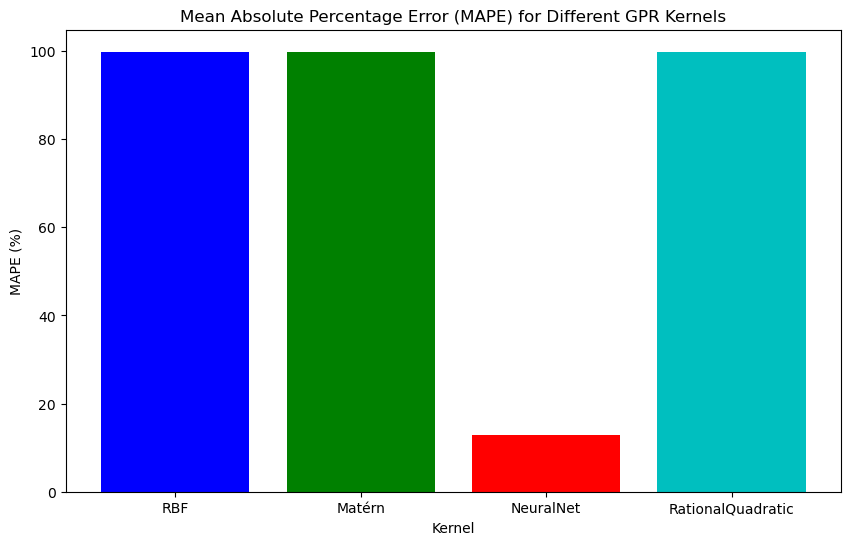

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel, RationalQuadratic
from sklearn.preprocessing import StandardScaler

# Ensure the date column is in datetime format
monthly_data['settlement_date'] = pd.to_datetime(monthly_data['settlement_date'])

# Convert dates to numerical format (Unix timestamp)
X = monthly_data[['settlement_date']].apply(lambda x: x.astype('int64') / 10**9)  # Time in seconds since epoch
y = monthly_data['england_wales_demand']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the kernels for the GPR models
kernels = {
    'RBF': RBF(length_scale=1.0) + WhiteKernel(noise_level=1),
    'Matérn': Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1),
    'NeuralNet': DotProduct(sigma_0=1.0) + WhiteKernel(noise_level=1),
    'RationalQuadratic': RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel(noise_level=1)
}

# Dictionary to store MAPE results for each kernel
mape_results = {}

# Train, predict, and evaluate each GPR model
for kernel_name, kernel in kernels.items():
    print(f"Training Gaussian Process Regressor with {kernel_name} kernel...")
    # Initialize Gaussian Process Regressor with increased alpha for stability
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, random_state=42)
    try:
        # Fit the model
        gpr.fit(X_train, y_train)
        # Predict on the test set
        y_pred = gpr.predict(X_test)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        # Store the MAPE result
        mape_results[kernel_name] = mape
        print(f"MAPE for {kernel_name} kernel: {mape:.2f}%")
    except np.linalg.LinAlgError as e:
        print(f"Failed to train GPR with {kernel_name} kernel due to: {e}")

# Convert MAPE results to a DataFrame for plotting
mape_df = pd.DataFrame(list(mape_results.items()), columns=['Kernel', 'MAPE'])

# Plot the MAPE values for different kernels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(mape_df['Kernel'], mape_df['MAPE'], color=['b', 'g', 'r', 'c'])
plt.title('Mean Absolute Percentage Error (MAPE) for Different GPR Kernels')
plt.xlabel('Kernel')
plt.ylabel('MAPE (%)')
plt.show()
